# Analysis of the Bosch data set

This notebook analyzes the Bosch data set and extracts meta-data for further processing from it.


The initial labelling file `signs004_ground_truth.csv` contains 16.133 instances with the following data (per row):
* Filename
* Width
* Height
* Roi.X1
* Roi.Y1
* Roi.X2
* Roi.Y2
* ClassId    

The additional labeling files added in April (`signs001_ground_truth.csv`, `signs003_ground_truth.csv`, `signs006_ground_truth.csv`) contain an additional 2.695, 6.421 and 12.870 instances each, respectively. Data ordering remains the same

---
### 1) Import and Preview

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import pickle
import seaborn as sns

from matplotlib import pyplot as plt

load sign name dict

In [2]:
with open('../sign_recognition/dict/sign_names_dict.pkl', 'rb') as f:
    sign_names = pickle.load(f)

In [3]:
import sys
print(sys.version_info)
df = pd.read_csv('signs004_ground_truth.csv')
df['ClassId'].replace(sign_names, inplace=True)
df.head()  # prints top 5 rows

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00001.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%)
1,00001.png,640,480,364,167,412,212,Parken Bereich (parking zone)
2,00002.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%)
3,00002.png,640,480,364,167,412,212,Parken Bereich (parking zone)
4,00003.png,640,480,5,174,49,209,Gefaelle 10% (downhill 10%)


Evaluate additionally labeled videos

In [4]:
import os

previously_labeled = 'signs004_ground_truth.csv'

frames_added_april = []
for filename in os.listdir(os.getcwd()):
    if filename.endswith('.csv') and filename != previously_labeled:
        frames_added_april.append(pd.read_csv(filename))

df_added_april = pd.concat(frames_added_april)
df_added_april['ClassId'].replace(sign_names, inplace=True)
df_added_april.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00001.png,640,480,488,487,745,746,Vorfahrt Gewaehren (give way to incoming)
1,00002.png,640,480,487,259,536,304,Vorfahrt Gewaehren (give way to incoming)
2,00003.png,640,480,487,259,536,304,Vorfahrt Gewaehren (give way to incoming)
3,00004.png,640,480,487,259,536,304,Vorfahrt Gewaehren (give way to incoming)
4,00005.png,640,480,487,259,536,304,Vorfahrt Gewaehren (give way to incoming)


---
### 2) Plotting the Label Distribution

1. First plot shows the distribution over the full dataset (including 'empty' images).
2. Second plot illustrates the true label distribution.
3. Additional data about the data set (min, max, exact class distribution)

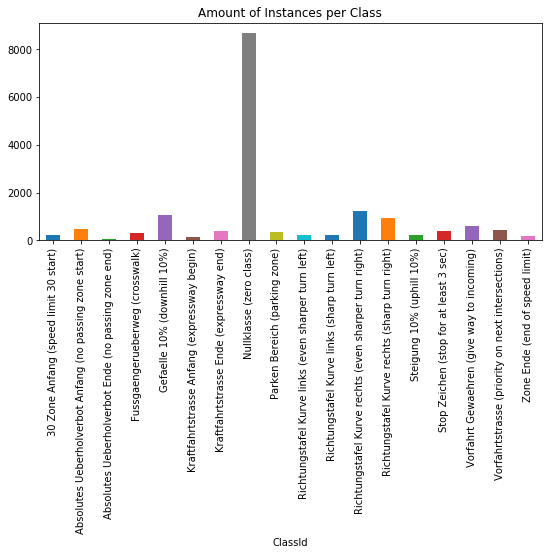

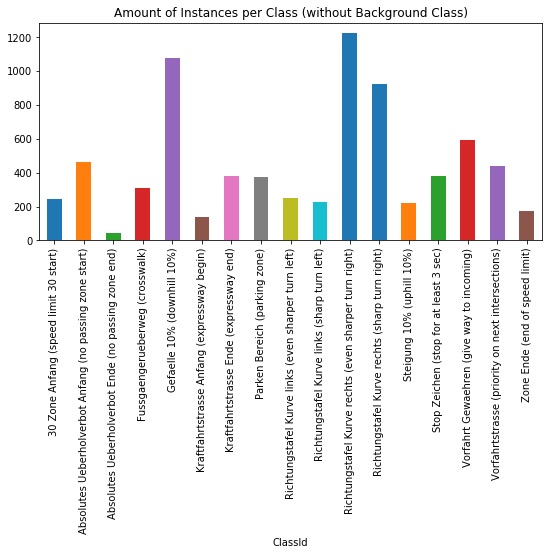

  Total Amount: 16134
Minimum Amount: 41
Maximum Amount: 8669
 Without empty: 7465

                                              ClassId  Amount
0               30 Zone Anfang (speed limit 30 start)     242
1   Absolutes Ueberholverbot Anfang (no passing zo...     466
2   Absolutes Ueberholverbot Ende (no passing zone...      41
3                     Fussgaengerueberweg (crosswalk)     311
4                         Gefaelle 10% (downhill 10%)    1077
5         Kraftfahrtstrasse Anfang (expressway begin)     141
6             Kraftfahrtstrasse Ende (expressway end)     378
7                             Nullklasse (zero class)    8669
8                       Parken Bereich (parking zone)     372
9   Richtungstafel Kurve links (even sharper turn ...     248
10       Richtungstafel Kurve links (sharp turn left)     228
11  Richtungstafel Kurve rechts (even sharper turn...    1224
12     Richtungstafel Kurve rechts (sharp turn right)     924
13                          Steigung 10% (uphill

In [5]:
# 1) Plot the distribution (with background class).
grouped_classes = df.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
grouped_classes.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class', legend=False)
plt.show()

# 2) Plot without background class.
df_without_background = df.drop(df[df['ClassId'] == sign_names[43]].index)
df_without_background_grouped = df_without_background.groupby('ClassId').count()['Width']
df_without_background_grouped.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class (without Background Class)', legend=False)
plt.show()
df_without_background_grouped = df_without_background_grouped.reset_index()
df_without_background_grouped.columns = ['ClassId', 'Amount']

# 3) Print statistics.
grouped_classes = grouped_classes.reset_index()  # Makes the index go from 0-17.
grouped_classes.columns = ['ClassId', 'Amount']  # Column renaming
print("  Total Amount: {}".format(grouped_classes['Amount'].sum()))
print("Minimum Amount: {}".format(grouped_classes['Amount'].min()))
print("Maximum Amount: {}".format(grouped_classes['Amount'].max()))
print(" Without empty: {}\n".format(grouped_classes['Amount'].sum() - grouped_classes['Amount'].max()))
print(grouped_classes)

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


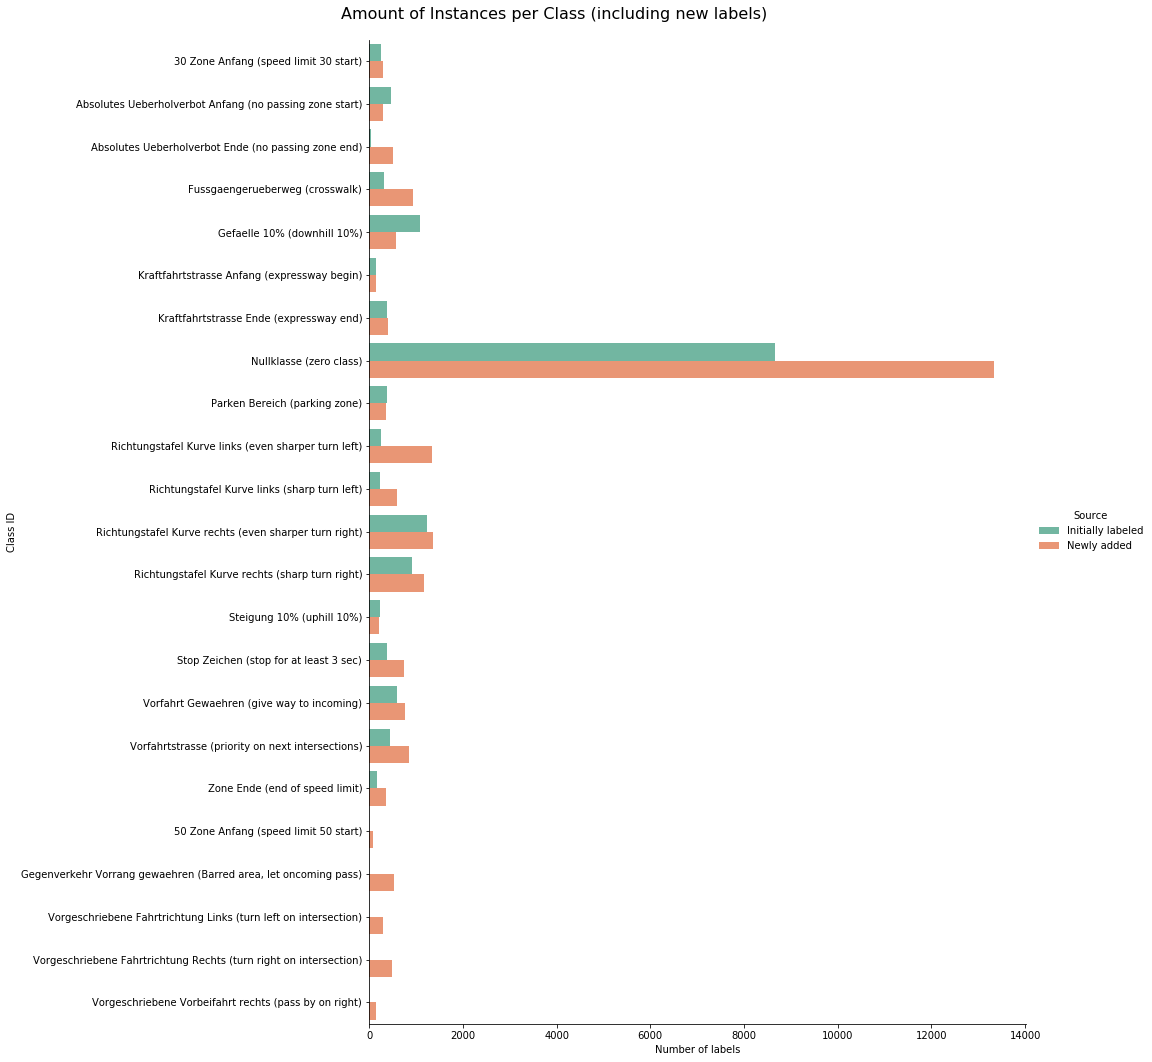

In [6]:
# 4) Plot the distribution with the newly added data
grouped_original = df.groupby(['ClassId']).count()
grouped_new = df_added_april.groupby(['ClassId']).count()
df_comparison = pd.concat([grouped_original, grouped_new], axis=0, ignore_index=False)
df_comparison['Source'] = (len(grouped_original)*('Initially labeled',) + len(grouped_new)*('Newly added',))
df_comparison.reset_index(level=0, inplace=True)
df_comparison.rename(columns={'ClassId': 'Class ID'}, inplace=True)
df_comparison['Number of labels'] = df_comparison['Filename']
df_comparison_wstop = df_comparison.copy()
df_comparison_wstop['Class ID'].replace(sign_names, inplace=True)
all_classes_plot = sns.factorplot(y='Class ID', x='Number of labels', hue='Source', kind='bar', 
                                  data=df_comparison_wstop, size=15, palette="Set2", orient='h')
all_classes_plot.fig.subplots_adjust(top=0.95)
all_classes_plot.fig.suptitle('Amount of Instances per Class (including new labels)', fontsize=16)
plt.show()

/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.5/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


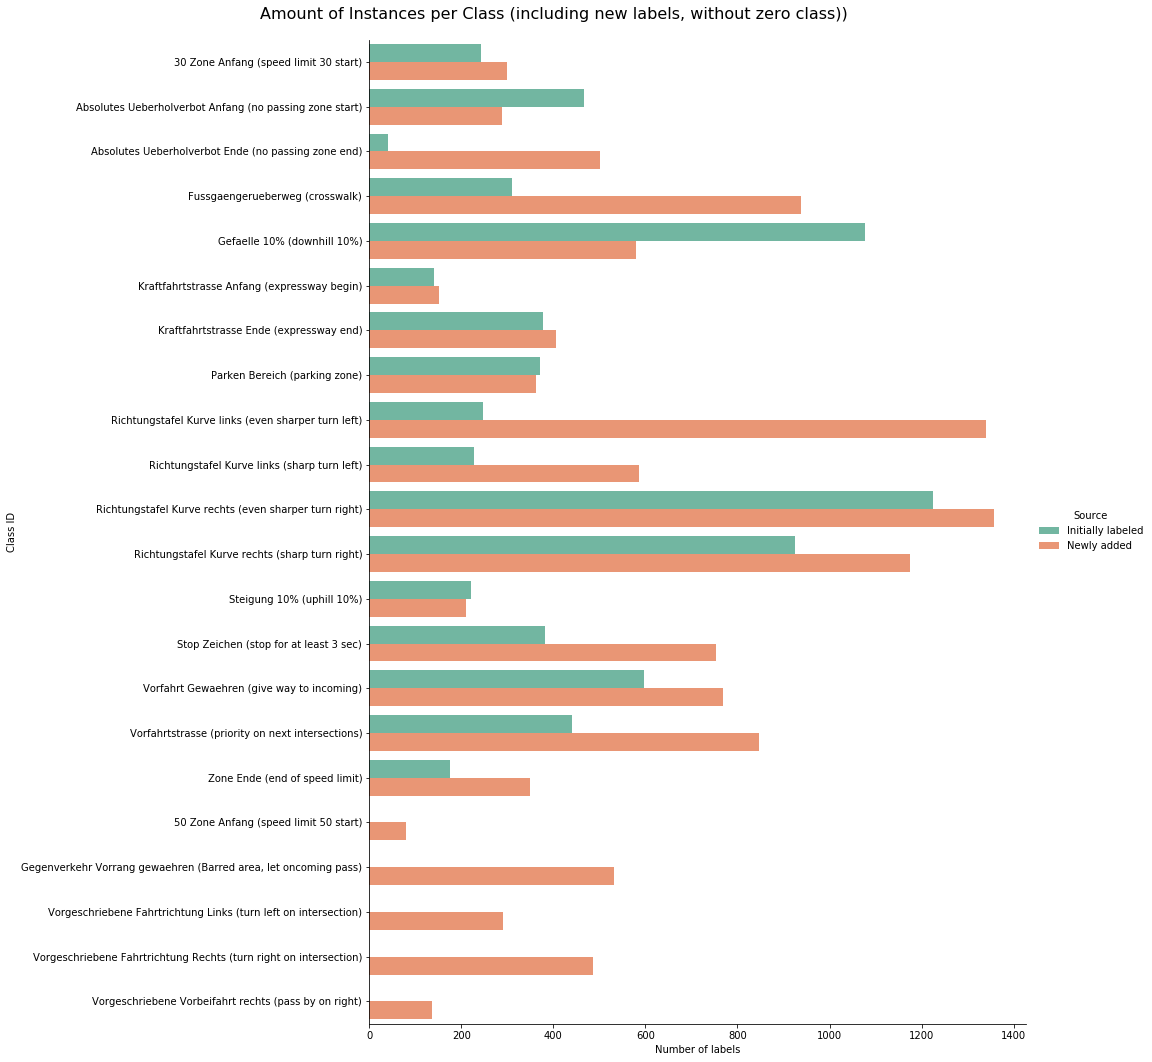

In [7]:
# 5) Plot the distribution with the newly added data, but without the zero class
df_comparison.drop(df_comparison[df_comparison['Class ID'] == sign_names[43]].index, inplace=True)
df_comparison['Class ID'].replace(sign_names, inplace=True)
all_classes_plot = sns.factorplot(y='Class ID', x='Number of labels', hue='Source', kind='bar', 
                                  data=df_comparison, size=15, palette="Set2", orient='h')
all_classes_plot.fig.subplots_adjust(top=0.95)
all_classes_plot.fig.suptitle('Amount of Instances per Class (including new labels, without zero class))', fontsize=16)
plt.show()

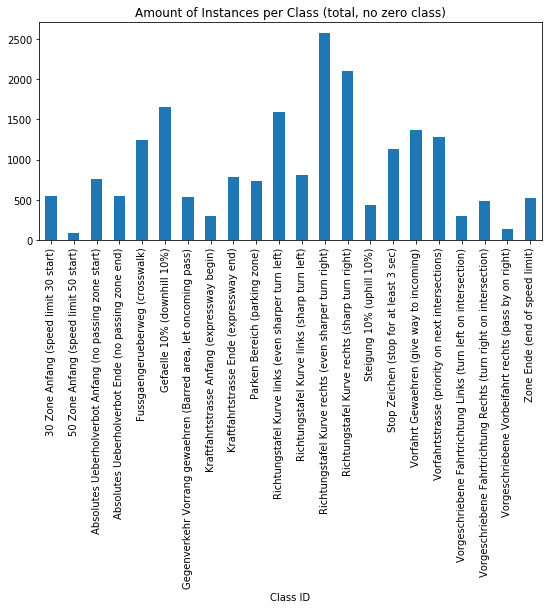

  Total Amount: 19904
Minimum Amount: 81
Maximum Amount: 2582
 Without empty: 11235

Class ID
30 Zone Anfang (speed limit 30 start)                                 542
50 Zone Anfang (speed limit 50 start)                                  81
Absolutes Ueberholverbot Anfang (no passing zone start)               755
Absolutes Ueberholverbot Ende (no passing zone end)                   542
Fussgaengerueberweg (crosswalk)                                      1248
Gefaelle 10% (downhill 10%)                                          1656
Gegenverkehr Vorrang gewaehren (Barred area, let oncoming pass)       532
Kraftfahrtstrasse Anfang (expressway begin)                           293
Kraftfahrtstrasse Ende (expressway end)                               784
Parken Bereich (parking zone)                                         735
Richtungstafel Kurve links (even sharper turn left)                  1588
Richtungstafel Kurve links (sharp turn left)                          813
Richtungstafel Kur

In [8]:
# 6) display total statistics
df_all = pd.concat([df, df_added_april])
df_all = df_all.groupby('ClassId').count()
df_all.drop(sign_names[43], inplace=True)
df_all = df_all[['Filename']]
df_all.reset_index(inplace=True)
df_all.columns = ['Class ID', 'Amount']
#df_all['Class ID'].replace(sign_names, inplace=True)
df_all.set_index('Class ID', inplace=True)

#all_grouped_classes = df_all.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
df_all.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class (total, no zero class)',
            legend=False)
plt.show()

print("  Total Amount: {}".format(df_all['Amount'].sum()))
print("Minimum Amount: {}".format(df_all['Amount'].min()))
print("Maximum Amount: {}".format(df_all['Amount'].max()))
print(" Without empty: {}\n".format(df_all['Amount'].sum() - grouped_classes['Amount'].max()))
print(df_all['Amount'])

---
### 4) Clean for "Time-Axis"

Since all images are taken from a video with 30 fps, most of them show the same scene (even the same pixels with little to no difference to the previous images). This is especially obvious if you inspect a series of images belonging to the same street sign. As a consequence those images yield no variety during training (no generalization) and only amplify overfitting.

Therefore, we want to get as much **distinct** images as possible. A trivial approach to achieve this, is to drop all images that are too *close in time* to a *base image*. E.g. a 2 second scene showing a *give way* sign, which corresponds to ~60 images. Given the heuristic, we drop x images that are too close to *image y*. x being 15 and y being the first image in this series, we would only keep the images [1, 16, 31, 46].

In [9]:
# We want to distinguish between images that are to close to one another in time .
# e.g. mulitple images from the same 1 second long video snippet.


# We want to get the frame time.
df_clean = pd.concat([df, df_added_april])
df_clean['TrackFrame'] = df_clean['Filename']  # Copy the Filename column.
df_clean['TrackFrame'] = df_clean['TrackFrame'].str.extract('(\d{5})', expand=True).astype(int)  # Extract the frame sequence number.

classes = df_without_background_grouped['ClassId'].values  # Get all ClassIds (without background)

amount_keep = dict((cl, 0) for cl in classes)
amount_drop = dict((cl, 0) for cl in classes)

index_to_drop = []

for cl in classes:
    track_frames = df_clean[df_clean['ClassId'] == cl]['TrackFrame'].values  # Get all FrameIDs.
    
    running_track_frame = 0
    keep_amount, drop_amount = 0, 0
    
    for track_frame in track_frames:
        if (track_frame - running_track_frame) > 15:  # entries to keep
            running_track_frame = track_frame
            keep_amount += 1
        else:  # entries to drop
            to_drop = df_clean[(df_clean['ClassId'] == cl) & (df_clean['TrackFrame'] == track_frame)]
            drop_amount += 1
            index_to_drop.append(to_drop.index.values[0])
    
    amount_keep[cl] = keep_amount
    amount_drop[cl] = drop_amount

#print(index_to_drop)
df_clean = df_clean.drop(df_clean.index[sorted(index_to_drop)])
df_clean = df_clean.drop(df_clean[df_clean['ClassId'] == sign_names[43]].index)
        
print("Images per class that are being kept: ", amount_keep)
print("\nImages per class that are being droped: ", amount_drop)

print("\nImage-Count before: {}".format(df_all['Amount'].sum()-grouped_classes['Amount'].max()))
print("Image-Count after:  {}".format(len(df_clean)))

Images per class that are being kept:  {'Stop Zeichen (stop for at least 3 sec)': 25, 'Gefaelle 10% (downhill 10%)': 69, 'Richtungstafel Kurve links (even sharper turn left)': 28, 'Kraftfahrtstrasse Anfang (expressway begin)': 11, '30 Zone Anfang (speed limit 30 start)': 17, 'Richtungstafel Kurve rechts (sharp turn right)': 62, 'Steigung 10% (uphill 10%)': 15, 'Zone Ende (end of speed limit)': 20, 'Parken Bereich (parking zone)': 33, 'Absolutes Ueberholverbot Anfang (no passing zone start)': 34, 'Absolutes Ueberholverbot Ende (no passing zone end)': 23, 'Vorfahrt Gewaehren (give way to incoming)': 40, 'Vorfahrtstrasse (priority on next intersections)': 30, 'Richtungstafel Kurve links (sharp turn left)': 15, 'Fussgaengerueberweg (crosswalk)': 26, 'Richtungstafel Kurve rechts (even sharper turn right)': 81, 'Kraftfahrtstrasse Ende (expressway end)': 27}

Images per class that are being droped:  {'Stop Zeichen (stop for at least 3 sec)': 1109, 'Gefaelle 10% (downhill 10%)': 1587, 'Richtun

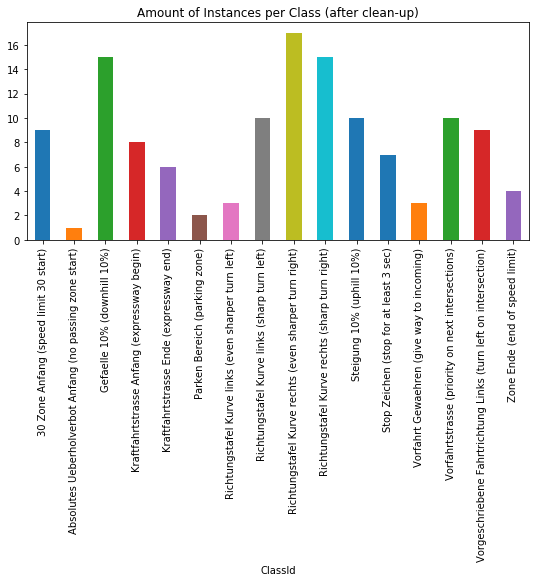

ClassId
30 Zone Anfang (speed limit 30 start)                               9
Absolutes Ueberholverbot Anfang (no passing zone start)             1
Gefaelle 10% (downhill 10%)                                        15
Kraftfahrtstrasse Anfang (expressway begin)                         8
Kraftfahrtstrasse Ende (expressway end)                             6
Parken Bereich (parking zone)                                       2
Richtungstafel Kurve links (even sharper turn left)                 3
Richtungstafel Kurve links (sharp turn left)                       10
Richtungstafel Kurve rechts (even sharper turn right)              17
Richtungstafel Kurve rechts (sharp turn right)                     15
Steigung 10% (uphill 10%)                                          10
Stop Zeichen (stop for at least 3 sec)                              7
Vorfahrt Gewaehren (give way to incoming)                           3
Vorfahrtstrasse (priority on next intersections)                   10
Vorgeschrieb

In [10]:
df_clean_plot = df_clean.groupby('ClassId').count()['Width']  # Group the dataframe by classes.
df_clean_plot.plot(kind='bar', figsize=(9,4),  title='Amount of Instances per Class (after clean-up)', legend=False)
plt.show()

print(df_clean_plot)

### 5) Compare with external datasets

Compare previously assembled data with additional signs gathered from existing datasets (in convert_datasets.ipynb).

In [11]:
frames_from_datasets = []
for filename in os.listdir(os.getcwd()):
    if filename.endswith('.csv'):
        frames_from_datasets.append(pd.read_csv(filename))
        
df_labeled = pd.concat(frames_from_datasets)
df_labeled.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00001.png,640,480,488,487,745,746,13
1,00002.png,640,480,487,259,536,304,13
2,00003.png,640,480,487,259,536,304,13
3,00004.png,640,480,487,259,536,304,13
4,00005.png,640,480,487,259,536,304,13


In [12]:
from export_locations import export_locations
filenames_from_datasets = export_locations.values()

frames_from_datasets = [pd.read_csv(filename) for filename in filenames_from_datasets]

df_datasets = pd.concat(frames_from_datasets)
df_datasets.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,ClassId,Filename,Roi.X1,Roi.X2,Roi.Y1,Roi.Y2,filename
0,12,01/image.006902.jp2,1470.19,1539.72,99.08,172.49,NaN
1,12,01/image.006903.jp2,1142.04,1178.95,171.84,207.96,NaN
2,12,01/image.006904.jp2,1028.69,1053.38,196.00,221.14,NaN
3,12,05/image.006905.jp2,1557.33,1601.90,311.01,353.74,NaN
4,12,05/image.006906.jp2,1160.45,1183.16,330.35,352.55,NaN


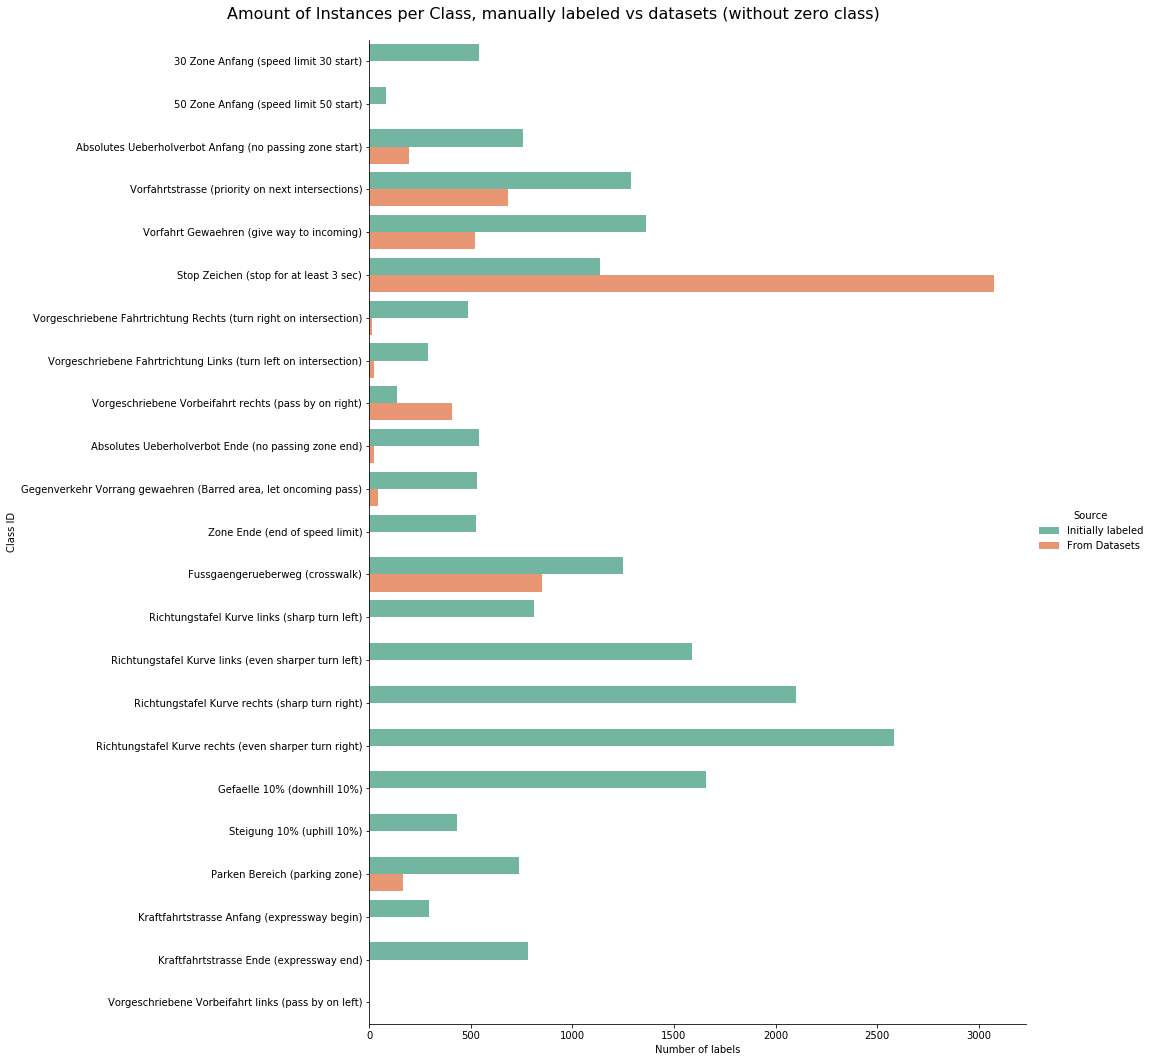

In [13]:
grouped_labeled = df_labeled.groupby(['ClassId']).count()
grouped_dataset = df_datasets.groupby(['ClassId']).count()
df_comparison = pd.concat([grouped_labeled, grouped_dataset], sort=True, axis=0, ignore_index=False)
df_comparison['Source'] = (len(grouped_labeled)*('Initially labeled',) + len(grouped_dataset)*('From Datasets',))
df_comparison.reset_index(level=0, inplace=True)
df_comparison.rename(columns={'ClassId': 'Class ID'}, inplace=True)
df_comparison['Number of labels'] = df_comparison['Filename']
df_comparison['Class ID'].replace(sign_names, inplace=True)
df_comparison.drop(df_comparison[df_comparison['Class ID'] == sign_names[43]].index, inplace=True)
all_classes_plot = sns.catplot(y='Class ID', x='Number of labels', hue='Source', kind='bar', 
                               data=df_comparison, height=15, palette="Set2", orient='h')
all_classes_plot.fig.subplots_adjust(top=0.95)
all_classes_plot.fig.suptitle('Amount of Instances per Class, manually labeled vs datasets (without zero class)', fontsize=16)
plt.show()